In [73]:
import pandas as pd
import xarray as xr
import numpy as np
import copy
import math
import random
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextlib
import io
import matplotlib

import calliope
from calliope.exceptions import ModelWarning

calliope.set_log_verbosity(verbosity='critical', include_solver_output=False, capture_warnings=False)

# Suppress the specific ModelWarning from Calliope
warnings.filterwarnings("ignore", category=ModelWarning)

from deap import base
from deap import creator
from deap import tools

In [56]:
model = calliope.Model('C:/Users/Jacob/Desktop/PythonProjects/Calliope with miniforge3/GAMGA-Calliope v3.9/GAMGA_model/model.yaml')

model.run()

c:\Users\Jacob\miniconda3\envs\calliope\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [1]:
model.plot.timeseries()


NameError: name 'model' is not defined

In [58]:
df_total_cost = model.results.cost.to_series().dropna()
total_cost_optimal = df_total_cost.loc[~df_total_cost.index.map(str).str.contains('co2_emissions')].sum()

total_cost_optimal

28493084.401176054

In [59]:
#Create the list of updates that need to be made to the model

energy_cap_df = model.results.energy_cap.to_pandas()
filtered_energy_cap_df = energy_cap_df[~energy_cap_df.index.str.contains("demand|transmission")]

print(filtered_energy_cap_df)

initial_capacities = filtered_energy_cap_df.values 
max_cap_value = max(filtered_energy_cap_df)

print(max_cap_value)



loc_techs
region1::ccgt        5000.000000
region2::solarPV2    8901.808507
region1::solarPV1       0.000076
region2::battery2    3079.980247
region1::battery1       0.000557
dtype: float64
8901.808506837464


In [60]:
updates = [
    {'tech': tech, 'loc': loc}
    for loc_tech in filtered_energy_cap_df.index
    for loc, tech in [loc_tech.split("::")]  # Split index by '::' to separate loc and tech
]

print(updates)

[{'tech': 'ccgt', 'loc': 'region1'}, {'tech': 'solarPV2', 'loc': 'region2'}, {'tech': 'solarPV1', 'loc': 'region1'}, {'tech': 'battery2', 'loc': 'region2'}, {'tech': 'battery1', 'loc': 'region1'}]


In [61]:
input_params = model.backend.access_model_inputs()

# Access energy_cap_max and energy_cap_min
energy_cap_max = input_params['energy_cap_max']
energy_cap_min = input_params['energy_cap_min']

# Convert to DataFrame for filtering
energy_cap_max_df = energy_cap_max.to_dataframe()
energy_cap_min_df = energy_cap_min.to_dataframe()

# Filter out rows with 'demand' or 'free' in the index
energy_cap_max_filtered = energy_cap_max_df[~energy_cap_max_df.index.get_level_values('loc_techs').str.contains("demand|transmission")]
energy_cap_min_filtered = energy_cap_min_df[~energy_cap_min_df.index.get_level_values('loc_techs').str.contains("demand|transmission")]

lowup = [
    [energy_cap_min_filtered.loc[loc_tech, 'energy_cap_min'], energy_cap_max_filtered.loc[loc_tech, 'energy_cap_max']]
    for loc_tech in energy_cap_max_filtered.index
]

low_up_bound = copy.deepcopy(lowup)

for i, (low, up) in enumerate(low_up_bound):
    if up == float('inf'):
        print(f"technology {i} has 'inf' as the upper bound.")
        low_up_bound[i][1] = max_cap_value
    
    else:
        print(f"technology {i} has a finite upper bound: {up}")

print("Updated low_up_bound:", low_up_bound)



technology 0 has a finite upper bound: 5000.0
technology 1 has a finite upper bound: 15000.0
technology 2 has a finite upper bound: 15000.0
technology 3 has a finite upper bound: 10000.0
technology 4 has a finite upper bound: 10000.0
Updated low_up_bound: [[0.0, 5000.0], [0.0, 15000.0], [0.0, 15000.0], [0.0, 10000.0], [0.0, 10000.0]]


In [62]:
#input variables
NUM_SUBPOPS = 3
SUBPOP_SIZE = 10 #must be even due to cross0ver
CROSSR, INDCROSS = 0.4 , 0.5 # % change that crossover (CXPB) or mutation (MUTPB) will occur for individuals (not variables in individuals. That is indb)
MUTR, INDMUT = 1, 0.1 # % change that crossover (CXPB) or mutation (MUTPB) will occur for variables in individuals (not individuals)
ETAV = 0.5 #small value (1 or smaller) creates different values from parents, high value (20 or higher) creates resembling values
GENERATIONS = 100

# changing values/resolution after n amount of generations
value_change_1 = 30  

# feasibility values
optimal_value = total_cost_optimal
max_slack = 0.2

unmetdemandpenalty = 300

# techs that are being adjusted
updates = [
    {'tech': tech, 'loc': loc}
    for loc_tech in filtered_energy_cap_df.index
    for loc, tech in [loc_tech.split("::")]  # Split index by '::' to separate loc and tech
]


In [63]:
def update_energy_cap_max_for_individual(model, updates, individual_values):
    
    # Ensure the length of updates matches the individual's values
    if len(updates) != len(individual_values):
        raise ValueError("Length of updates and individual values must match.")
    
    # Update the model with the individual's capacity values
    for update, new_cap in zip(updates, individual_values):
        tech = update['tech']
        loc = update['loc']
        
        # Construct the location::technology key and update the model
        loc_tech_key = f"{loc}::{tech}"
        model.backend.update_param('energy_cap_max', {loc_tech_key: new_cap})
        model.backend.update_param('energy_cap_min', {loc_tech_key: new_cap})
    
    # Run the model for this individual
    try:
        rerun_model = model.backend.rerun()  # Rerun to capture updated backend parameters

        # Calculate the total cost, excluding emission costs
        cost_op = rerun_model.results.cost.to_series().dropna()
        initial_cost = round(cost_op.loc[~cost_op.index.map(str).str.contains('co2_emissions')].sum(), 2)

        unmet = rerun_model.results.unmet_demand.to_series().dropna()
        unmet_demand = round(unmet.sum() * unmetdemandpenalty, 2)

        total_cost = initial_cost + unmet_demand
    
    except Exception as e:
        # If solving fails, set total cost to NaN and print a warning
        total_cost = float('inf')
        print("Warning: Model could not be solved for the individual. Assigning cost as infinite.")
    
    return total_cost

def slack_feasibility(individual):
    cost = update_energy_cap_max_for_individual(model, updates, individual)
    individual.cost = cost  # Attach cost attribute to individual
    slack_distance = (cost - optimal_value) / optimal_value

    # Update feasibility condition based on the new criteria
    feasible = slack_distance <= max_slack #and cost >= optimal_value

    print(f"Slack feasibility for individual: {feasible}, Cost: {individual.cost}")
    
    return feasible 

def centroidSP(subpop):
    centroids = []

    # Iterate over each subpopulation and calculate the centroid
    for sub in subpop.values():
        if not isinstance(sub, list) or not all(isinstance(individual, list) for individual in sub):
            raise TypeError("Each subpopulation must be a list of lists (individuals).")
        
        num_solutions = len(sub)  # Number of solutions in the current subpopulation
        num_variables = len(sub[0])  # Number of decision variables
        
        # Calculate the centroid for each decision variable
        centroid = [sum(solution[i] for solution in sub) / num_solutions for i in range(num_variables)]
        centroids.append(centroid)  # Append each centroid to the main list in the required format
    
    return centroids

def fitness(subpop, centroids):
    distances = []
    minimal_distances = []
    fitness_SP = {}

    # Step 1: Calculate Distances per Variable for each individual
    for q, (subpop_index, subpopulation) in enumerate(subpop.items()):
        subpopulation_distances = []
        
        for individual in subpopulation:
            individual_variable_distances = []
            
            for p, centroid in enumerate(centroids):
                if p != q:  # Skip the centroid of the same subpopulation
                    variable_distances = [abs(individual[i] - centroid[i]) for i in range(len(individual))]
                    individual_variable_distances.append(variable_distances)
            
            subpopulation_distances.append(individual_variable_distances)
        
        distances.append(subpopulation_distances)

    # Step 2: Calculate Minimal Distances per Variable
    for subpopulation_distances in distances:
        subpopulation_minimal = []
        
        for individual_distances in subpopulation_distances:
            min_distance_per_variable = [min(distance[i] for distance in individual_distances) for i in range(len(individual_distances[0]))]
            subpopulation_minimal.append(min_distance_per_variable)
        
        minimal_distances.append(subpopulation_minimal)

    # Step 3: Calculate Fitness SP for each individual
    for sp_index, subpopulation in enumerate(minimal_distances, start=1):
        fitness_values = [(min(individual),) for individual in subpopulation]
        fitness_SP[sp_index] = fitness_values

    return fitness_SP

def load_model_with_scenario(scenario_name):
    """
    Load the Calliope model with the specified scenario and update the optimal cost.
    """
    # Load the model with the given scenario
    model = calliope.Model("C:/Users/Jacob/Desktop/PythonProjects/Calliope with miniforge3/DEAP-Calliope v3.9/my_new_model/model.yaml", scenario=scenario_name)
    model.run()  # Run the model once to initialize it with the chosen resolution
    
    # Calculate the optimal cost after running the model
    df_total_cost = model.results.cost.to_series().dropna()
    total_cost_optimal = df_total_cost.loc[~df_total_cost.index.map(str).str.contains('co2_emissions')].sum()
    
    #Update the global optimal value
    global optimal_value
    optimal_value = total_cost_optimal  # Set optimal_value to the new optimal cost
    
    print(f"Optimal cost updated for scenario '{scenario_name}': {optimal_value}")
    
    return model

def custom_tournament(subpopulation, k, tournsize=2):
    selected = []
    zero_fitness_count = 0  # Counter for individuals with fitness (0,)

    while len(selected) < k:
        # Randomly select `tournsize` individuals for the tournament
        tournament = random.sample(subpopulation, tournsize)

        # Check if all individuals in the tournament have a fitness of (0,)
        if all(ind.fitness.values == (0,) for ind in tournament):
            if zero_fitness_count < 2:
                # Select the individual with the lowest cost if all fitness values are (0,)
                best = min(tournament, key=lambda ind: ind.cost)
                selected.append(best)
                zero_fitness_count += 1
            else:
                # Select a random feasible individual if we've reached the max count of (0,) fitness values
                feasible_individuals = [ind for ind in subpopulation if ind.fitness.values != (0,)]
                if feasible_individuals:
                    best = random.choice(feasible_individuals)
                    selected.append(best)
                else:
                    # If no feasible individuals are available, fallback to random selection to avoid empty selection
                    best = random.choice(subpopulation)
                    selected.append(best)
        else:
            # Select based on fitness if there are feasible individuals in the tournament
            best = max(tournament, key=lambda ind: ind.fitness.values[0])
            selected.append(best)

    return selected

def attr_variable_range(index):
    # Extract the bounds for the gene
    min_val, max_val = low_up_bound[index]
    # Get the initial capacity value for this index
    initial_value = initial_capacities[index]

    if initial_value > 1000:
        # Allow a 10% variation for higher values
        variation = 0.1 * initial_value
    else:
        # Fixed variation for low values with an additional 1% of the upper bound
        variation = 1.0 + 0.1 * max_val

    # Calculate the range constrained by bounds and variation
    lower_bound = max(min_val, initial_value - variation)
    upper_bound = min(max_val, initial_value + variation)

    # Generate a random value within this constrained range
    return random.uniform(lower_bound, upper_bound)


In [64]:
creator.create("FitnessMaxDist", base.Fitness, weights=(1.0,))  # Fitness to maximize distinctiveness
creator.create("IndividualSP", list, fitness=creator.FitnessMaxDist, cost=0)  # Individual structure in DEAP

# Function to generate an individual
def generate_individual():
    return [attr_variable_range(i) for i in range(len(low_up_bound))]

# DEAP toolbox setup
toolbox = base.Toolbox()

# Register the individual and subpopulation initializers
toolbox.register("individualSP", tools.initIterate, creator.IndividualSP, generate_individual)
toolbox.register("subpopulationSP", tools.initRepeat, list, toolbox.individualSP)

#register the operators
toolbox.register("mate", tools.cxUniform)
toolbox.register("elitism", tools.selBest, fit_attr="fitness.values")
toolbox.register("select", custom_tournament)
toolbox.register("mutbound", tools.mutPolynomialBounded)

# Generate subpopulations with multiple individuals
subpops_unaltered = [toolbox.subpopulationSP(n=SUBPOP_SIZE) for _ in range(NUM_SUBPOPS)]

subpops_SP = {}

for p in range(NUM_SUBPOPS):
    subpops_SP[p+1] = subpops_unaltered[p]

c:\Users\Jacob\miniconda3\envs\calliope\lib\site-packages\deap\creator.py:185: RuntimeWarning:

A class named 'FitnessMaxDist' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

c:\Users\Jacob\miniconda3\envs\calliope\lib\site-packages\deap\creator.py:185: RuntimeWarning:

A class named 'IndividualSP' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.



In [65]:
#calculate centroids and fitness
centroids = centroidSP(subpops_SP)
fitness_populations = fitness(subpops_SP, centroids)

# Combine the fitness values with each individual
for i, subpopulation in subpops_SP.items():
    for individual, fit in zip(subpopulation, fitness_populations[i]):
        individual.fitness.values = fit 

for subpop_index, subpopulation in subpops_SP.items():      
    # Calculate slack feasibility and set fitness accordingly. This is also where the cost gets assigned as an attribute to the individual
    for individual in subpopulation:
        slack_validity = slack_feasibility(individual)
        if slack_validity:
            individual.fitness.values = individual.fitness.values
        else:
            individual.fitness.values = (0,)
                
        print(f"Fitness for Individual in Subpopulation {subpop_index}: {individual.fitness.values}")

Slack feasibility for individual: True, Cost: 29193935.009999998
Fitness for Individual in Subpopulation 1: (22.553878078699654,)
Slack feasibility for individual: True, Cost: 32629885.89
Fitness for Individual in Subpopulation 1: (7.32630971855167,)
Slack feasibility for individual: True, Cost: 29983872.099999998
Fitness for Individual in Subpopulation 1: (19.948269004723443,)
Slack feasibility for individual: True, Cost: 30239118.16
Fitness for Individual in Subpopulation 1: (49.362786598298044,)
Slack feasibility for individual: True, Cost: 30153803.13
Fitness for Individual in Subpopulation 1: (7.800885882321381,)
Slack feasibility for individual: True, Cost: 33249311.22
Fitness for Individual in Subpopulation 1: (84.5073584869524,)
Slack feasibility for individual: True, Cost: 29353936.04
Fitness for Individual in Subpopulation 1: (51.201605292170825,)
Slack feasibility for individual: True, Cost: 31378494.06
Fitness for Individual in Subpopulation 1: (3.1221807805959543,)
Slack f

In [ ]:
# Initialize containers to store the fitness statistics
avg_fitness_per_gen = {i: [] for i in range(1, NUM_SUBPOPS + 1)}  # For average fitness (existing logic)
highest_fitness_per_gen = {i: [] for i in range(1, NUM_SUBPOPS + 1)}  # For highest fitness
highest_fitness_sum_per_gen = []  # For sum of highest fitness values across subpopulations

low = [b[0] for b in low_up_bound]
up = [b[1] for b in low_up_bound]

g = 0
while g < GENERATIONS: 
    g += 1
    print(f"-- Generation {g} --")

    offspring = {}
    highest_fitness_sum = 0  # Initialize the sum of highest fitness for this generation

    for subpop_index, subpopulation in subpops_SP.items():
        # Compute and store fitness values, excluding (0,) fitness values
        fitness_values = [ind.fitness.values[0] for ind in subpopulation if ind.fitness.values[0] != 0]

        # Calculate the average fitness (existing logic)
        if fitness_values:
            avg_fitness = sum(fitness_values) / len(fitness_values)
        else:
            avg_fitness = 0
        avg_fitness_per_gen[subpop_index].append(avg_fitness)

        # Calculate the highest fitness
        if fitness_values:
            highest_fitness = max(fitness_values)
        else:
            highest_fitness = 0
        highest_fitness_per_gen[subpop_index].append(highest_fitness)

        # Add to the total highest fitness sum for this generation
        highest_fitness_sum += highest_fitness



        # Select the next generation individuals
        elite_count = int(0.2 * len(subpopulation))
        # Preserve the top 10% as elites and select the rest through tournament selection
        offspring[subpop_index] = (toolbox.elitism(subpopulation, elite_count) + toolbox.select(subpopulation, (len(subpopulation) - elite_count)))

        # Clone the selected individuals
        offspring[subpop_index] = list(map(toolbox.clone, offspring[subpop_index]))




        # Apply crossover
        for child1, child2 in zip(offspring[subpop_index][::2], offspring[subpop_index][1::2]): 
            if random.random() < CROSSR:  # Use updated crossover probability
                toolbox.mate(child1, child2, indpb=INDCROSS) 
                del child1.fitness.values 
                del child2.fitness.values 

        # Apply mutation
        for mutant in offspring[subpop_index]:
            if random.random() <= MUTR:
                # Apply mutPolynomialBounded with shared bounds
                mutant, = toolbox.mutbound(mutant, low=low, up=up, eta=ETAV, indpb=INDMUT)
                mutant[:] = [max(0, val) for val in mutant]  # Ensure values are non-negative
                
                # Delete fitness to ensure re-evaluation
                if hasattr(mutant.fitness, 'values'):
                    del mutant.fitness.values

    # Append the total highest fitness sum for this generation
    highest_fitness_sum_per_gen.append(highest_fitness_sum)





    # Calculate centroids and fitness for offspring
    centroids_offspring = copy.deepcopy(centroidSP(offspring))
    fitness_SP_offspring = fitness(offspring, centroids_offspring)
    print("Calculated fitness for offspring:", fitness_SP_offspring)




    # Calculate slack feasibility and set fitness accordingly
    for subpop_index, subpopulation in offspring.items():
        for idx, individual in enumerate(subpopulation):
            # Check slack feasibility
            if len(individual.fitness.values) == 0:
                slack_validity = slack_feasibility(individual)
            
                if slack_validity:
                    individual.fitness.values = fitness_SP_offspring[subpop_index][idx]
                else:
                    individual.fitness.values = (0,)
                    
            else:
                slack_validity = True  # Assume valid if fitness is already assigned
                individual.fitness.values = fitness_SP_offspring[subpop_index][idx]

            # Get the cost (if not already assigned, set a default for safety)
            cost = getattr(individual, 'cost', 0)

            # Format fitness, cost, and individual values to 2 decimals
            fitness_str = f"{individual.fitness.values[0]:.2f}" if individual.fitness.values else "0.00"
            cost_str = f"{cost:.2f}"
            values_str = ", ".join(f"{val:.2f}" for val in individual)
        
            # Print in the requested format
            print(f"({slack_validity}), fitness: {fitness_str}, cost: {cost_str}, values: [{values_str}], subpop: {subpop_index}, individual: {idx}")




    if g == value_change_1:
        print("Changing parameters.")
        ETAV = 5

    subpops_SP = offspring

-- Generation 1 --
Calculated fitness for offspring: {1: [(4.0468964251704165,), (40.114159033655596,), (4.0468964251704165,), (15.887346928213447,), (33.85612560984464,), (15.887346928213447,), (15.887346928213447,), (4.0468964251704165,), (137.19359882040953,), (7.17802579536783,)], 2: [(80.51484091374368,), (11.832756225641788,), (109.5202647064234,), (11.832756225641788,), (31.93375345072218,), (132.76036311021198,), (132.76036311021198,), (132.76036311021198,), (68.36387158854632,), (4.246099919195899,)], 3: [(43.502726068983065,), (112.50897587842928,), (76.64480815493516,), (76.64480815493516,), (30.725039357147125,), (85.86768390672819,), (112.50897587842928,), (112.50897587842928,), (5.543615960656098,), (30.725039357147125,)]}
Slack feasibility for individual: False, Cost: 49121478.58
(False), fitness: 0.00, cost: 49121478.58, values: [4806.53, 1831.41, 1241.40, 3057.66, 603.29], subpop: 1, individual: 0
Slack feasibility for individual: True, Cost: 32994268.840000004
(True),

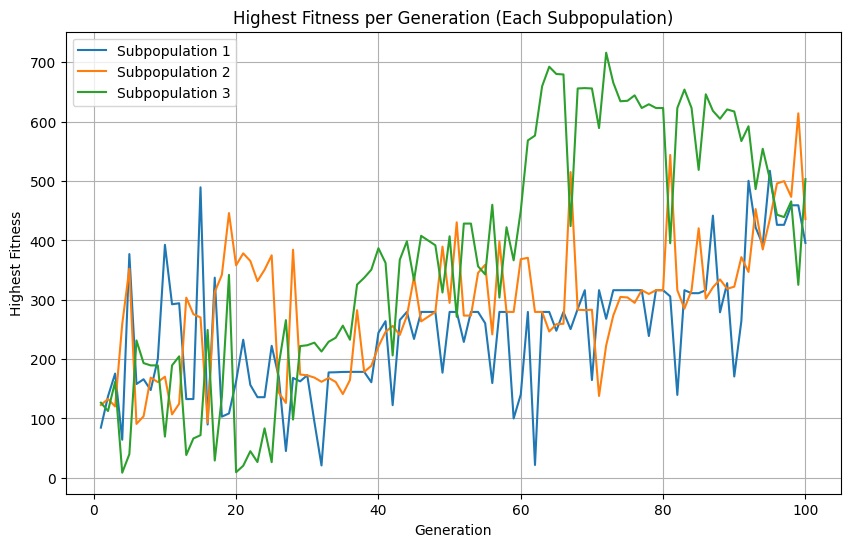

In [77]:
# Line graph for highest fitness per subpopulation
plt.figure(figsize=(10, 6))
for subpop_index, fitness_values in highest_fitness_per_gen.items():
    plt.plot(range(1, len(fitness_values) + 1), fitness_values, label=f"Subpopulation {subpop_index}")

plt.title("Highest Fitness per Generation (Each Subpopulation)")
plt.xlabel("Generation")
plt.ylabel("Highest Fitness")
plt.legend()
plt.grid()
plt.show()

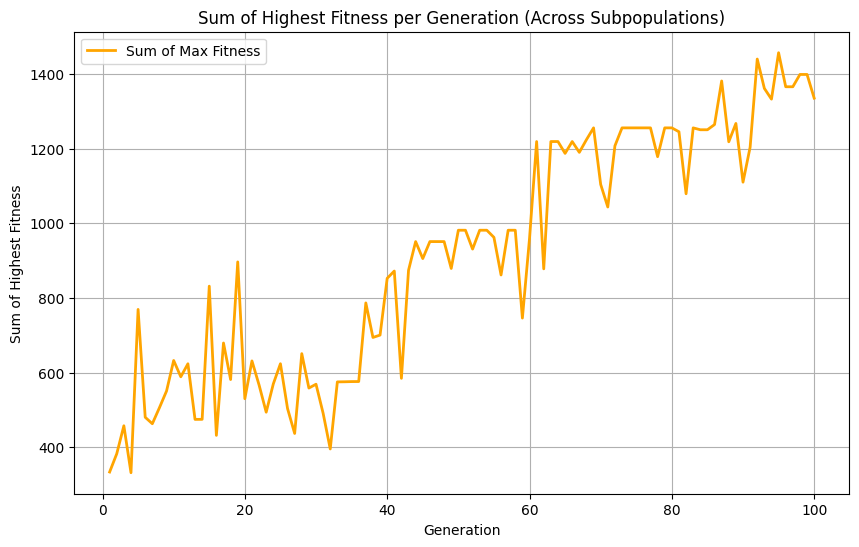

In [68]:
# Line graph for sum of highest fitness values across subpopulations
plt.figure(figsize=(10, 6))

# Use the actual length of `highest_fitness_sum_per_gen` for the x-axis
plt.plot(range(1, len(highest_fitness_sum_per_gen) + 1), highest_fitness_sum_per_gen, 
         label="Sum of Max Fitness", color='orange', linewidth=2)

plt.title("Sum of Highest Fitness per Generation (Across Subpopulations)")
plt.xlabel("Generation")
plt.ylabel("Sum of Highest Fitness")
plt.legend()
plt.grid()
plt.show()

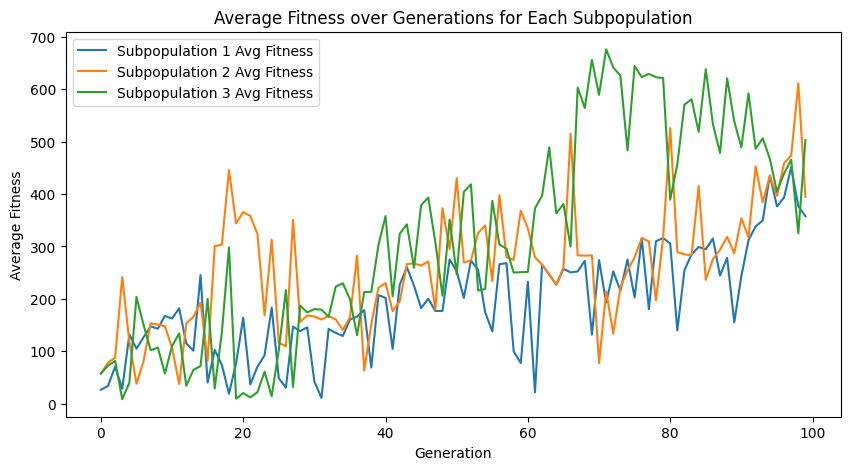

In [69]:
# Plot average fitness for each subpopulation
plt.figure(figsize=(10, 5))
for i in range(1, NUM_SUBPOPS + 1):
    plt.plot(avg_fitness_per_gen[i], label=f'Subpopulation {i} Avg Fitness')
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations for Each Subpopulation')
plt.legend()
plt.show()

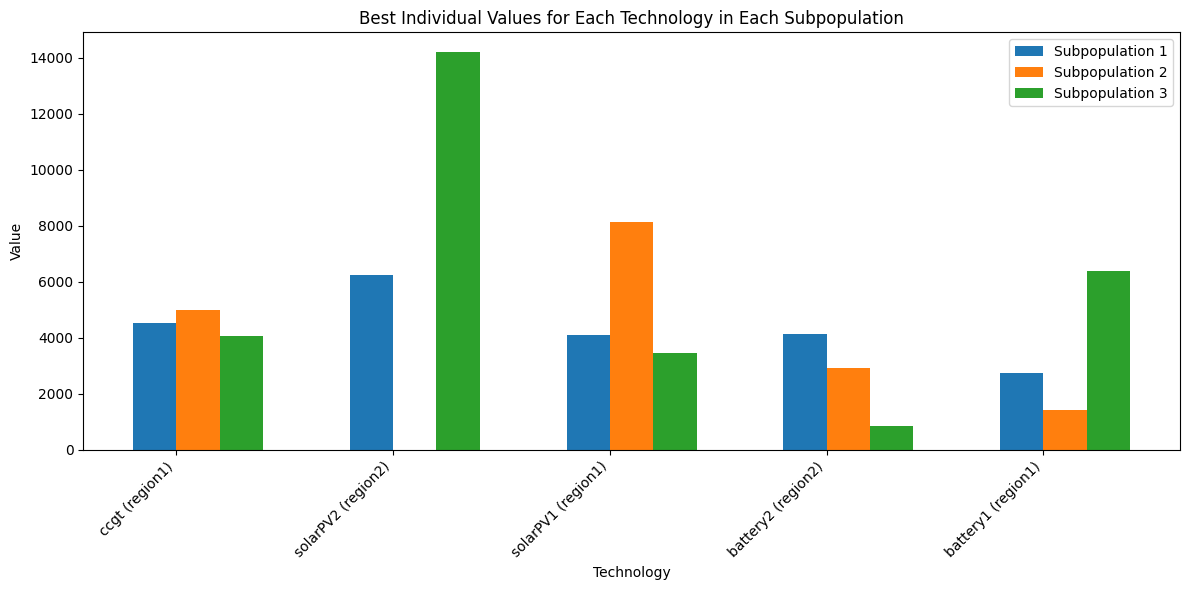

In [71]:
# Extract technology labels dynamically from the `updates` list
tech_labels = [f"{update['tech']} ({update['loc']})" for update in updates]

# Prepare data for the plot
x = np.arange(len(tech_labels))  # the label locations
width = 0.2  # the width of the bars

# Create the bar plot for best individuals' values
plt.figure(figsize=(12, 6))

for idx, (subpop_index, best_ind) in enumerate(best_individuals.items(), start=1):
    plt.bar(x + (idx - 1) * width, best_ind, width=width, label=f'Subpopulation {subpop_index}')

# Add labels and formatting
plt.xlabel('Technology')
plt.ylabel('Value')
plt.title('Best Individual Values for Each Technology in Each Subpopulation')
plt.xticks(x + width / 2, tech_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
